In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import glob

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19, Xception, DenseNet121

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2022-04-03 09:10:58.028955: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-03 09:10:58.029079: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
batch_size = 256
IMAGE_SIZE = [512, 512]
num_epochs = 65

## Set strategy

In [4]:
# Set distribution strategy to use TPUs
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
print('Found connected TPU: ', resolver.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

Found connected TPU:  ['10.0.0.2:8470']


2022-04-03 09:11:08.332853: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-03 09:11:08.335671: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-03 09:11:08.335714: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-03 09:11:08.335742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (200fe33bfd25): /proc/driver/nvidia/version does not exist
2022-04-03 09:11:08.338167: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [5]:
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
# TPU requires everything to be in a GCS bucket to work.

from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

gs://kds-9a365d3ed8f74882c0e1cdd9937a5f38d2a481ca22e04a5e63bcafda


## Read Images 

In [7]:
# list files
train_files = tf.io.gfile.glob(f'{GCS_DS_PATH}/tfrecords-jpeg-512x512/train/*')
val_files = tf.io.gfile.glob(f'{GCS_DS_PATH}/tfrecords-jpeg-512x512/val/*')
test_files = tf.io.gfile.glob(f'{GCS_DS_PATH}/tfrecords-jpeg-512x512/test/*')

2022-04-03 09:11:15.409538: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-03 09:11:15.561915: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-03 09:11:15.712837: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
# file name contains the number of samples in that tf record. 00-224x224-798.tfrec -> contains 798 samples.
def get_num_samples(file_list):
    count = 0 
    for file_name in file_list:
        num_sample = int(file_name.split('.tfrec')[0].rsplit('-', 1)[1])
        count += num_sample
    return count

### Sizes of each dataset

In [9]:
train_size = get_num_samples(train_files)
val_size = get_num_samples(val_files)
test_size = get_num_samples(test_files)

print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Test dataset size: {test_size}")

Train dataset size: 12753
Validation dataset size: 3712
Test dataset size: 7382


In [10]:
# Functions and 'classes' variable in this cell were taken from https://www.kaggle.com/code/ryanholbrook/create-your-first-submission/notebook

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

## Create TF data objects

In [11]:
train_dataset = tf.data.TFRecordDataset(train_files, num_parallel_reads=AUTO)
test_dataset = tf.data.TFRecordDataset(test_files, num_parallel_reads=AUTO)
val_dataset = tf.data.TFRecordDataset(val_files, num_parallel_reads=AUTO)

In [12]:
train_dataset = train_dataset.map(read_labeled_tfrecord)
train_dataset = train_dataset.map(data_augment, num_parallel_calls=AUTO)
train_dataset = train_dataset.shuffle(buffer_size=batch_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size=batch_size)
train_dataset = train_dataset.prefetch(buffer_size=batch_size)

In [13]:
val_dataset = val_dataset.map(read_labeled_tfrecord)
val_dataset = val_dataset.batch(batch_size=batch_size)
val_dataset = val_dataset.prefetch(buffer_size=batch_size)

In [14]:
test_dataset = test_dataset.map(read_unlabeled_tfrecord)
test_dataset = test_dataset.prefetch(buffer_size=batch_size)

## Build model

In [15]:
# VGG19 model
def create_densenet121_model():
    base_model = DenseNet121(
        weights='imagenet',
        input_shape=(512, 512, 3),
        include_top=False
    )
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(512, 512, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4112, activation='relu')(x)
    x = layers.Dense(2056, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    return model

## Callbacks

In [18]:
cp_callback = ModelCheckpoint(filepath='flower_model_densenet121.hdf5',
                              monitor='val_sparse_categorical_accuracy',
                              save_freq='epoch', verbose=1, period=1,
                              save_best_only=True, save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy',
                               verbose=1, patience=5, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.2, patience=2, 
                              verbose=1, mode='max', min_lr=1e-5,)

## Train

In [19]:
with strategy.scope():
    batch_size = batch_size * strategy.num_replicas_in_sync
    steps_per_epoch = int(train_size / batch_size)*2
    model = create_densenet121_model()
    history = model.fit(
                train_dataset, 
                validation_data=val_dataset,
                epochs=num_epochs,
                steps_per_epoch=steps_per_epoch,
                callbacks=[reduce_lr, cp_callback, early_stopping])

29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/65
12/12 [==============================] - 65s 3s/step - loss: 4.4000 - sparse_categorical_accuracy: 0.0675 - val_loss: 3.5319 - val_sparse_categorical_accuracy: 0.2287


2022-04-03 09:15:00.195444: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 37991, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1648977300.191945098","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 37991, Output num: 0","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.22872, saving model to flower_model_densenet121.hdf5
Epoch 2/65
12/12 [==============================] - 27s 2s/step - loss: 3.3563 - sparse_categorical_accuracy: 0.2389 - val_loss: 2.9075 - val_sparse_categorical_accuracy: 0.3168

Epoch 00002: val_sparse_categorical_accuracy improved from 0.22872 to 0.31681, saving model to flower_model_densenet121.hdf5
Epoch 3/65
12/12 [==============================] - 26s 2s/step - loss: 2.7944 - sparse_categorical_accuracy: 0.3394 - val_loss: 2.3679 - val_sparse_categorical_accuracy: 0.4391

Epoch 00003: val_sparse_categorical_accuracy improved from 0.31681 to 0.43912, saving model to flower_model_densenet121.hdf5
Epoch 4/65
12/12 [==============================] - 26s 2s/step - loss: 2.2349 - sparse_categorical_accuracy: 0.4569 - val_loss: 1.9967 - val_sparse_categorical_accuracy: 0.4935

Epoch 00004: val_sparse_categorical_accuracy improved from 0.43912 to 0.49353, saving mode

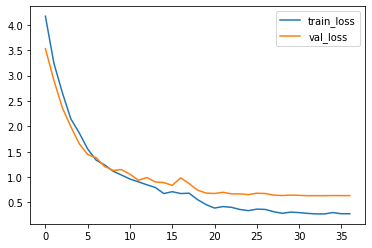

In [20]:
plt.plot(history.history['loss'], label='train_loss') 
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

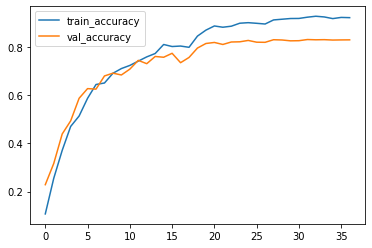

In [21]:
plt.plot(history.history['sparse_categorical_accuracy'], label='train_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend() 
plt.show()

In [24]:
model = create_densenet121_model()
model.load_weights('flower_model_densenet121.hdf5')

In [25]:
results = {'id': [], 'label': []}

## Test

In [26]:
def predict(element):
    image = element[0]
    id_ = tf.keras.backend.get_value(element[1]).decode("utf-8")
    result = list(model.predict(np.array([image]))[0])
    max_pred = max(result)
    result = result.index(max_pred)
    results['id'].append(id_)
    results['label'].append(result) 

In [27]:
count = 0
for row in test_dataset: 
    image = row[0]
    id_ = tf.keras.backend.get_value(row[1]).decode("utf-8")
    result = list(model.predict(np.array([image]))[0])
    max_pred = max(result) 
    result = result.index(max_pred) 
    results['id'].append(id_)
    results['label'].append(result)
    count += 1 
    if (count % 500) == 0:
        print(f"Finished predicting {count} images") 

Finished predicting 500 images
Finished predicting 1000 images
Finished predicting 1500 images
Finished predicting 2000 images
Finished predicting 2500 images
Finished predicting 3000 images
Finished predicting 3500 images
Finished predicting 4000 images
Finished predicting 4500 images
Finished predicting 5000 images
Finished predicting 5500 images
Finished predicting 6000 images
Finished predicting 6500 images
Finished predicting 7000 images


2022-04-03 10:01:27.937460: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 346371, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1648980087.937155711","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 346371, Output num: 0","grpc_status":3}


In [29]:
results_df = pd.DataFrame(results)
results_df.to_csv('submission.csv', index=False)